In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models_pytorch
from IPython.display import clear_output
clear_output()

In [ ]:
import os
import zipfile
import cv2
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random  # Import the random module
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [ ]:
"""
def unzip_recursive(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    with zipfile.ZipFile(src_dir, 'r') as zip_ref:
        zip_ref.extractall(dst_dir)

    for root, dirs, files in os.walk(dst_dir):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                new_dst_dir = os.path.join(root, file.replace('.zip', ''))
                unzip_recursive(file_path, new_dst_dir)
                os.remove(file_path)  # Optionally remove the zipped file after extraction

# Example usage:
src_zip_file = '/content/drive/MyDrive/with_pannels.zip'
dst_directory = '/content/drive/MyDrive/solar_panels_with_new_USA'

unzip_recursive(src_zip_file, dst_directory)
"""

"\ndef unzip_recursive(src_dir, dst_dir):\n    if not os.path.exists(dst_dir):\n        os.makedirs(dst_dir)\n\n    with zipfile.ZipFile(src_dir, 'r') as zip_ref:\n        zip_ref.extractall(dst_dir)\n\n    for root, dirs, files in os.walk(dst_dir):\n        for file in files:\n            if file.endswith('.zip'):\n                file_path = os.path.join(root, file)\n                new_dst_dir = os.path.join(root, file.replace('.zip', ''))\n                unzip_recursive(file_path, new_dst_dir)\n                os.remove(file_path)  # Optionally remove the zipped file after extraction\n\n# Example usage:\nsrc_zip_file = '/content/drive/MyDrive/with_pannels.zip'\ndst_directory = '/content/drive/MyDrive/solar_panels_with_new_USA'\n\nunzip_recursive(src_zip_file, dst_directory)\n"

In [ ]:
# Pre-processing of the australia data
scaler = MinMaxScaler()
root_directory = '/content/drive/MyDrive/DEEP LEARNING/Aus_unzip'

image_dataset = []
mask_dataset = []


for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for image_name in images:
            if image_name.endswith(".png"):
                image = cv2.imread(os.path.join(path, image_name), 1)
                image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                image_dataset.append(image)


for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for mask_name in masks:
            if mask_name.endswith(".png"):
                mask = cv2.imread(os.path.join(path, mask_name), 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask_dataset.append(mask)

image_dataset = np.array(image_dataset, dtype=np.float32)
mask_dataset = np.array(mask_dataset, dtype=np.uint8)


SolarPanel = [0, 0, 0]

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    label_seg[np.all(label == SolarPanel, axis=-1)] = 1
    return label_seg

labels = [rgb_to_2D_label(mask) for mask in mask_dataset]
labels = np.array(labels)
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


In [6]:
# Pre-processing of the USA data
scaler = MinMaxScaler()
root_directory_US = '/content/drive/MyDrive/DEEP LEARNING/USA'
desired_shape = (256, 256)  # Specify the desired shape

image_datasetUS = []
mask_datasetUS = []
max_images = 864


image_count = 0
for path, subdirs, files in os.walk(root_directory_US):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images1 = sorted(os.listdir(path))
        for image_name1 in images1:
            if image_name1.endswith(".png"):
                image_path = os.path.join(path, image_name1)
                mask_name = image_name1.replace('image', 'mask')
                mask_path = os.path.join(root_directory_US, 'masks', mask_name)
                print(f"Trying to read image: {image_path}")
                print(f"Trying to read mask: {mask_path}")


                if os.path.exists(mask_path):
                    image1 = cv2.imread(image_path, 1)
                    mask1 = cv2.imread(mask_path, 1)

                    if image1 is not None and mask1 is not None:
                        image1 = cv2.resize(image1, desired_shape)
                        image1 = scaler.fit_transform(image1.reshape(-1, image1.shape[-1])).reshape(image1.shape)
                        mask1 = cv2.resize(mask1, desired_shape)
                        mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)

                        image_datasetUS.append(image1)
                        mask_datasetUS.append(mask1)
                        image_count += 1

                        if image_count >= max_images:
                            break
                else:
                    print(f"Mask not found for image: {image_path}")
        if image_count >= max_images:
            break

image_datasetUS = np.array(image_datasetUS, dtype=np.float32)
mask_datasetUS = np.array(mask_datasetUS, dtype=np.uint8)


SolarPanel = [0, 0, 0]

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    label_seg[np.all(label == SolarPanel, axis=-1)] = 1
    return label_seg

labelsUS = [rgb_to_2D_label(mask) for mask in mask_datasetUS]
labelsUS = np.array(labelsUS)
print("Unique labels in label dataset are: ", np.unique(labelsUS))
print(f"Number of images loaded: {len(image_datasetUS)}")
print(f"Number of masks loaded: {len(mask_datasetUS)}")



Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_10240_2048.png
Trying to read mask: /content/drive/MyDrive/DEEP LEARNING/USA/masks/mask_10240_2048.png
Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_10240_2816.png
Trying to read mask: /content/drive/MyDrive/DEEP LEARNING/USA/masks/mask_10240_2816.png
Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_10240_3072.png
Trying to read mask: /content/drive/MyDrive/DEEP LEARNING/USA/masks/mask_10240_3072.png
Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_1024_0.png
Trying to read mask: /content/drive/MyDrive/DEEP LEARNING/USA/masks/mask_1024_0.png
Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_1024_1024.png
Trying to read mask: /content/drive/MyDrive/DEEP LEARNING/USA/masks/mask_1024_1024.png
Trying to read image: /content/drive/MyDrive/DEEP LEARNING/USA/images/image_1024_10240.png
Trying to read mask: /co

In [7]:

image_train, image_test, label_train, label_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)


image_train_US, image_test_US, label_train_US, label_test_US = train_test_split(image_datasetUS, labelsUS, test_size=751, random_state=42)

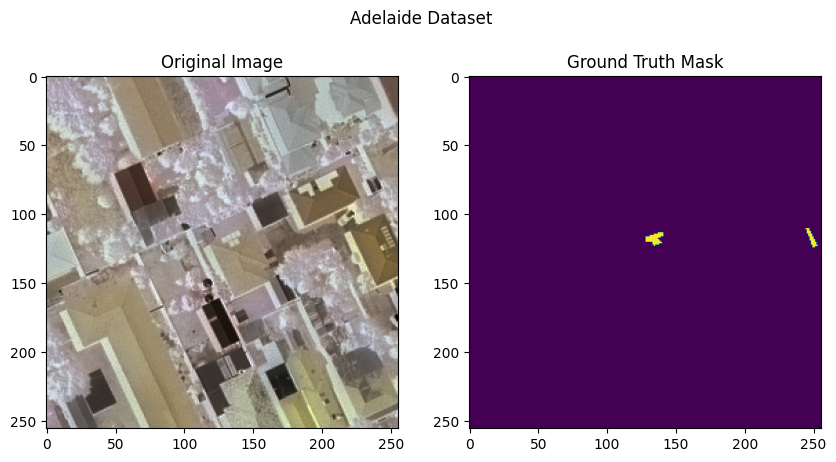

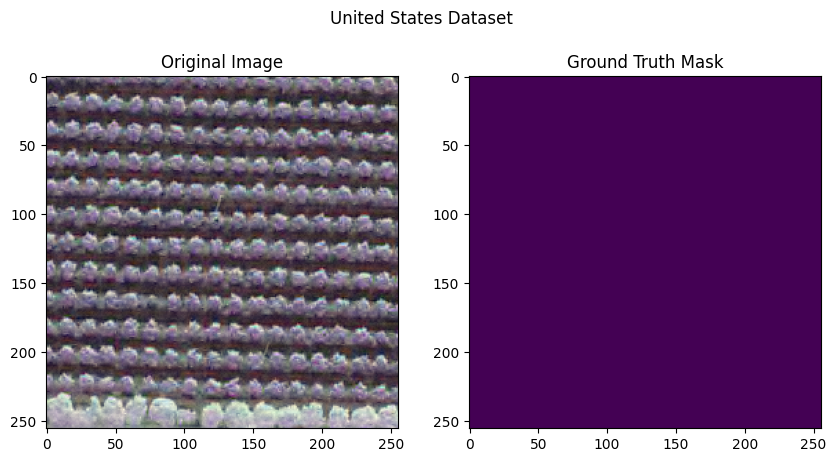

In [9]:

def display_sample(image, mask, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.suptitle(title)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.suptitle(title)
    plt.title('Ground Truth Mask')
    plt.show()


random_idx1 = random.randint(0, len(image_dataset) - 1)
display_sample(image_dataset[random_idx1], labels[random_idx1],"Adelaide Dataset")


random_idx2 = random.randint(0, len(image_datasetUS) - 1)
display_sample(image_datasetUS[random_idx2], labelsUS[random_idx2],"United States Dataset")

In [10]:

class AerialDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor()
])


train_dataset = AerialDataset(image_train, label_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = AerialDataset(image_test, label_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


train_dataset_US = AerialDataset(image_train_US, label_train_US, transform=transform)
train_dataloader_US = DataLoader(train_dataset_US, batch_size=4, shuffle=True)

test_dataset_US = AerialDataset(image_test_US, label_test_US, transform=transform)
test_dataloader_US = DataLoader(test_dataset_US, batch_size=4, shuffle=False)

In [11]:
NUM_CLASSES = 2  # 2 classes: background and solar panel
GPU = 0
SEED = 2023

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = smp.PSPNet("resnet50", classes=NUM_CLASSES, in_channels=3, encoder_weights=None)
model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_dataloader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    scheduler.step(epoch_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30, Loss: 0.0112
Epoch 2/30, Loss: 0.0068
Epoch 3/30, Loss: 0.0070
Epoch 4/30, Loss: 0.0057
Epoch 5/30, Loss: 0.0054
Epoch 6/30, Loss: 0.0051
Epoch 7/30, Loss: 0.0049
Epoch 8/30, Loss: 0.0045
Epoch 9/30, Loss: 0.0045
Epoch 10/30, Loss: 0.0040
Epoch 11/30, Loss: 0.0042
Epoch 12/30, Loss: 0.0037
Epoch 13/30, Loss: 0.0037
Epoch 14/30, Loss: 0.0037
Epoch 15/30, Loss: 0.0040
Epoch 16/30, Loss: 0.0040
Epoch 17/30, Loss: 0.0031
Epoch 18/30, Loss: 0.0029
Epoch 19/30, Loss: 0.0027
Epoch 20/30, Loss: 0.0026
Epoch 21/30, Loss: 0.0026
Epoch 22/30, Loss: 0.0024
Epoch 23/30, Loss: 0.0023
Epoch 24/30, Loss: 0.0022
Epoch 25/30, Loss: 0.0022
Epoch 26/30, Loss: 0.0021
Epoch 27/30, Loss: 0.0020
Epoch 28/30, Loss: 0.0020
Epoch 29/30, Loss: 0.0020
Epoch 30/30, Loss: 0.0019


In [14]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, preds, idx):
    image = images[idx].cpu().numpy().transpose(1, 2, 0)
    mask = masks[idx].cpu().numpy()
    pred = preds[idx].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[1].axis('off')

    axs[2].imshow(pred)
    axs[2].set_title('Predicted Mask', color='red' if np.any(pred == 1) else 'black')
    axs[2].axis('off')

    plt.show()

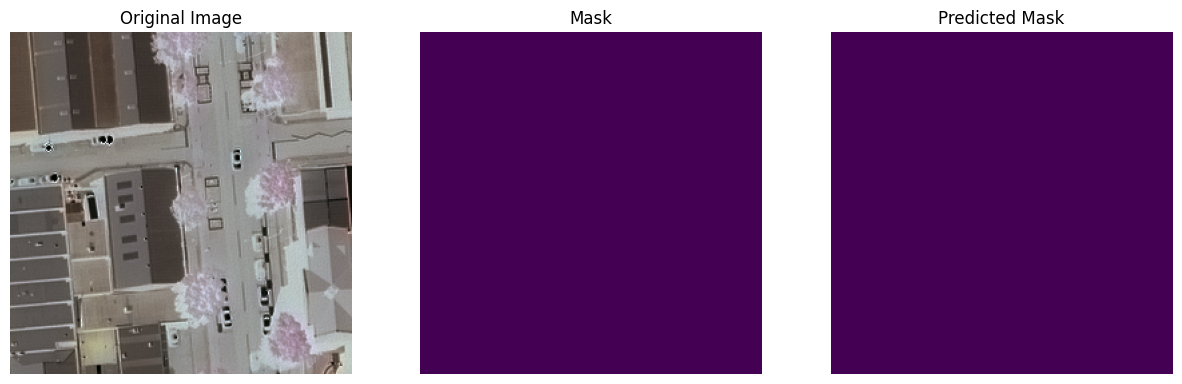

In [16]:

model.eval()
with torch.no_grad():
    for images, masks in train_dataloader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)


        visualize_predictions(images, masks, preds, 0)
        break

In [17]:

def calculate_miou(y_true, y_pred, num_classes):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    iou = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    return np.nanmean(iou)


def validate(model, dataloader, device, num_classes):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating"):
            images, masks = images.to(device, dtype=torch.float), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)


    miou = calculate_miou(all_masks, all_preds, num_classes)


    precision = precision_score(all_masks.flatten(), all_preds.flatten())
    recall = recall_score(all_masks.flatten(), all_preds.flatten())
    f1 = f1_score(all_masks.flatten(), all_preds.flatten())

    return miou, precision, recall, f1


num_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


miou1, precision1, recall1, f1_1 = validate(model, test_dataloader, device, num_classes)
print(f"Dataset 1 - mIoU: {miou1:.4f}, Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1-Score: {f1_1:.4f}")



Validating: 100%|██████████| 188/188 [00:02<00:00, 66.87it/s]


Dataset 1 - mIoU: 0.6224, Precision: 0.7169, Recall: 0.2724, F1-Score: 0.3948


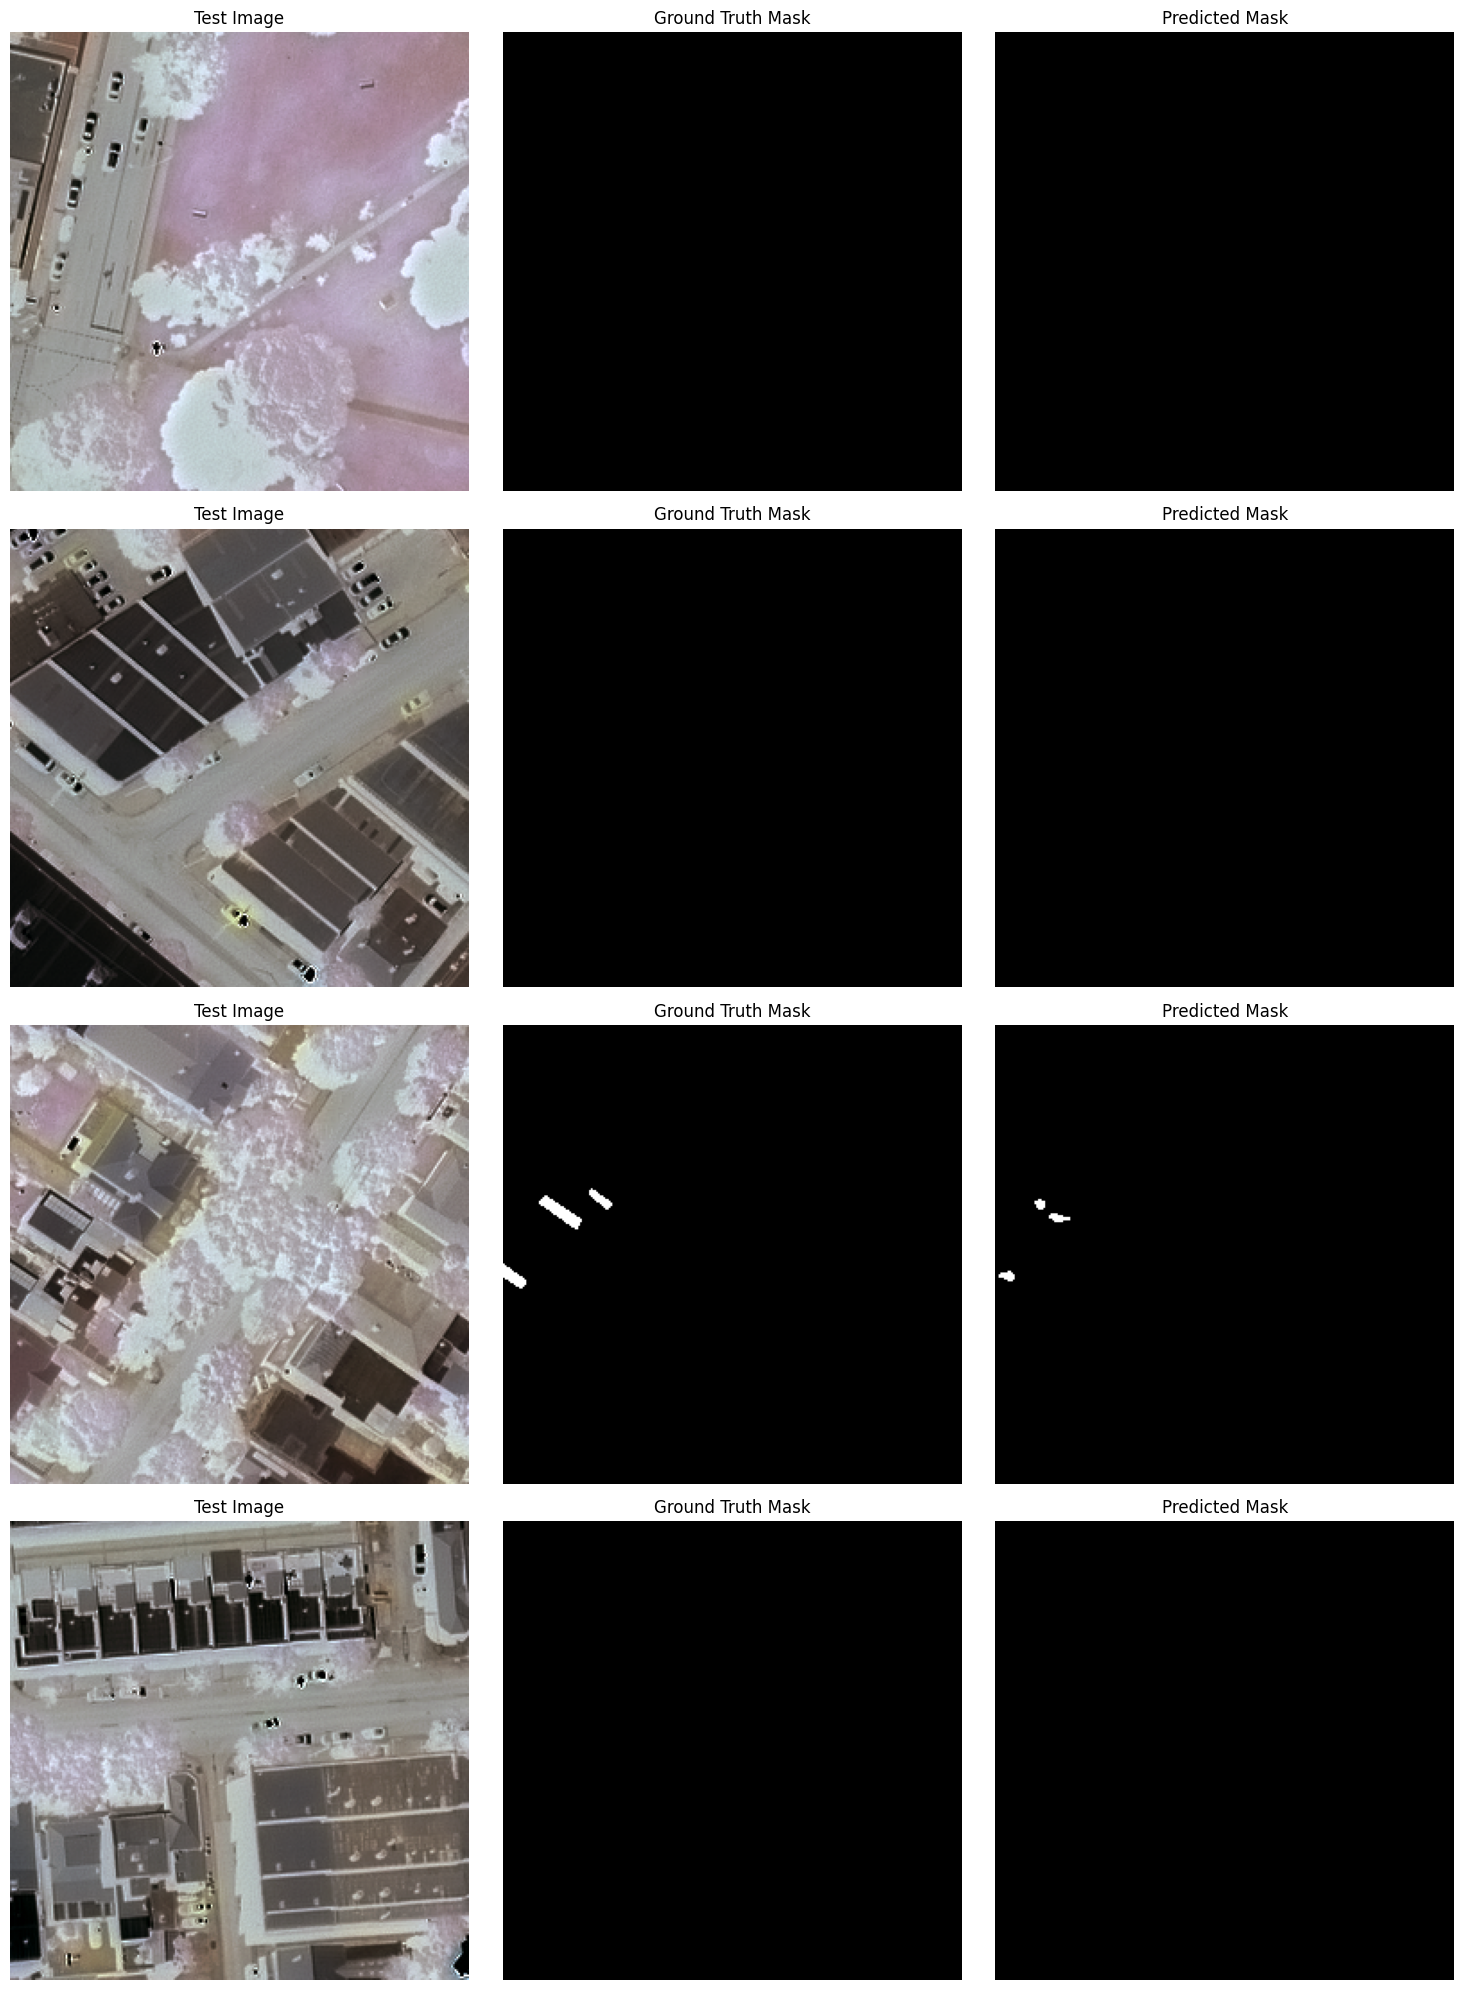

In [18]:
def plot_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device, dtype=torch.float), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()


    num_images = min(num_images, len(images))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].transpose(1, 2, 0))
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(preds[i], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


plot_predictions(model, test_dataloader, device, num_images=5)

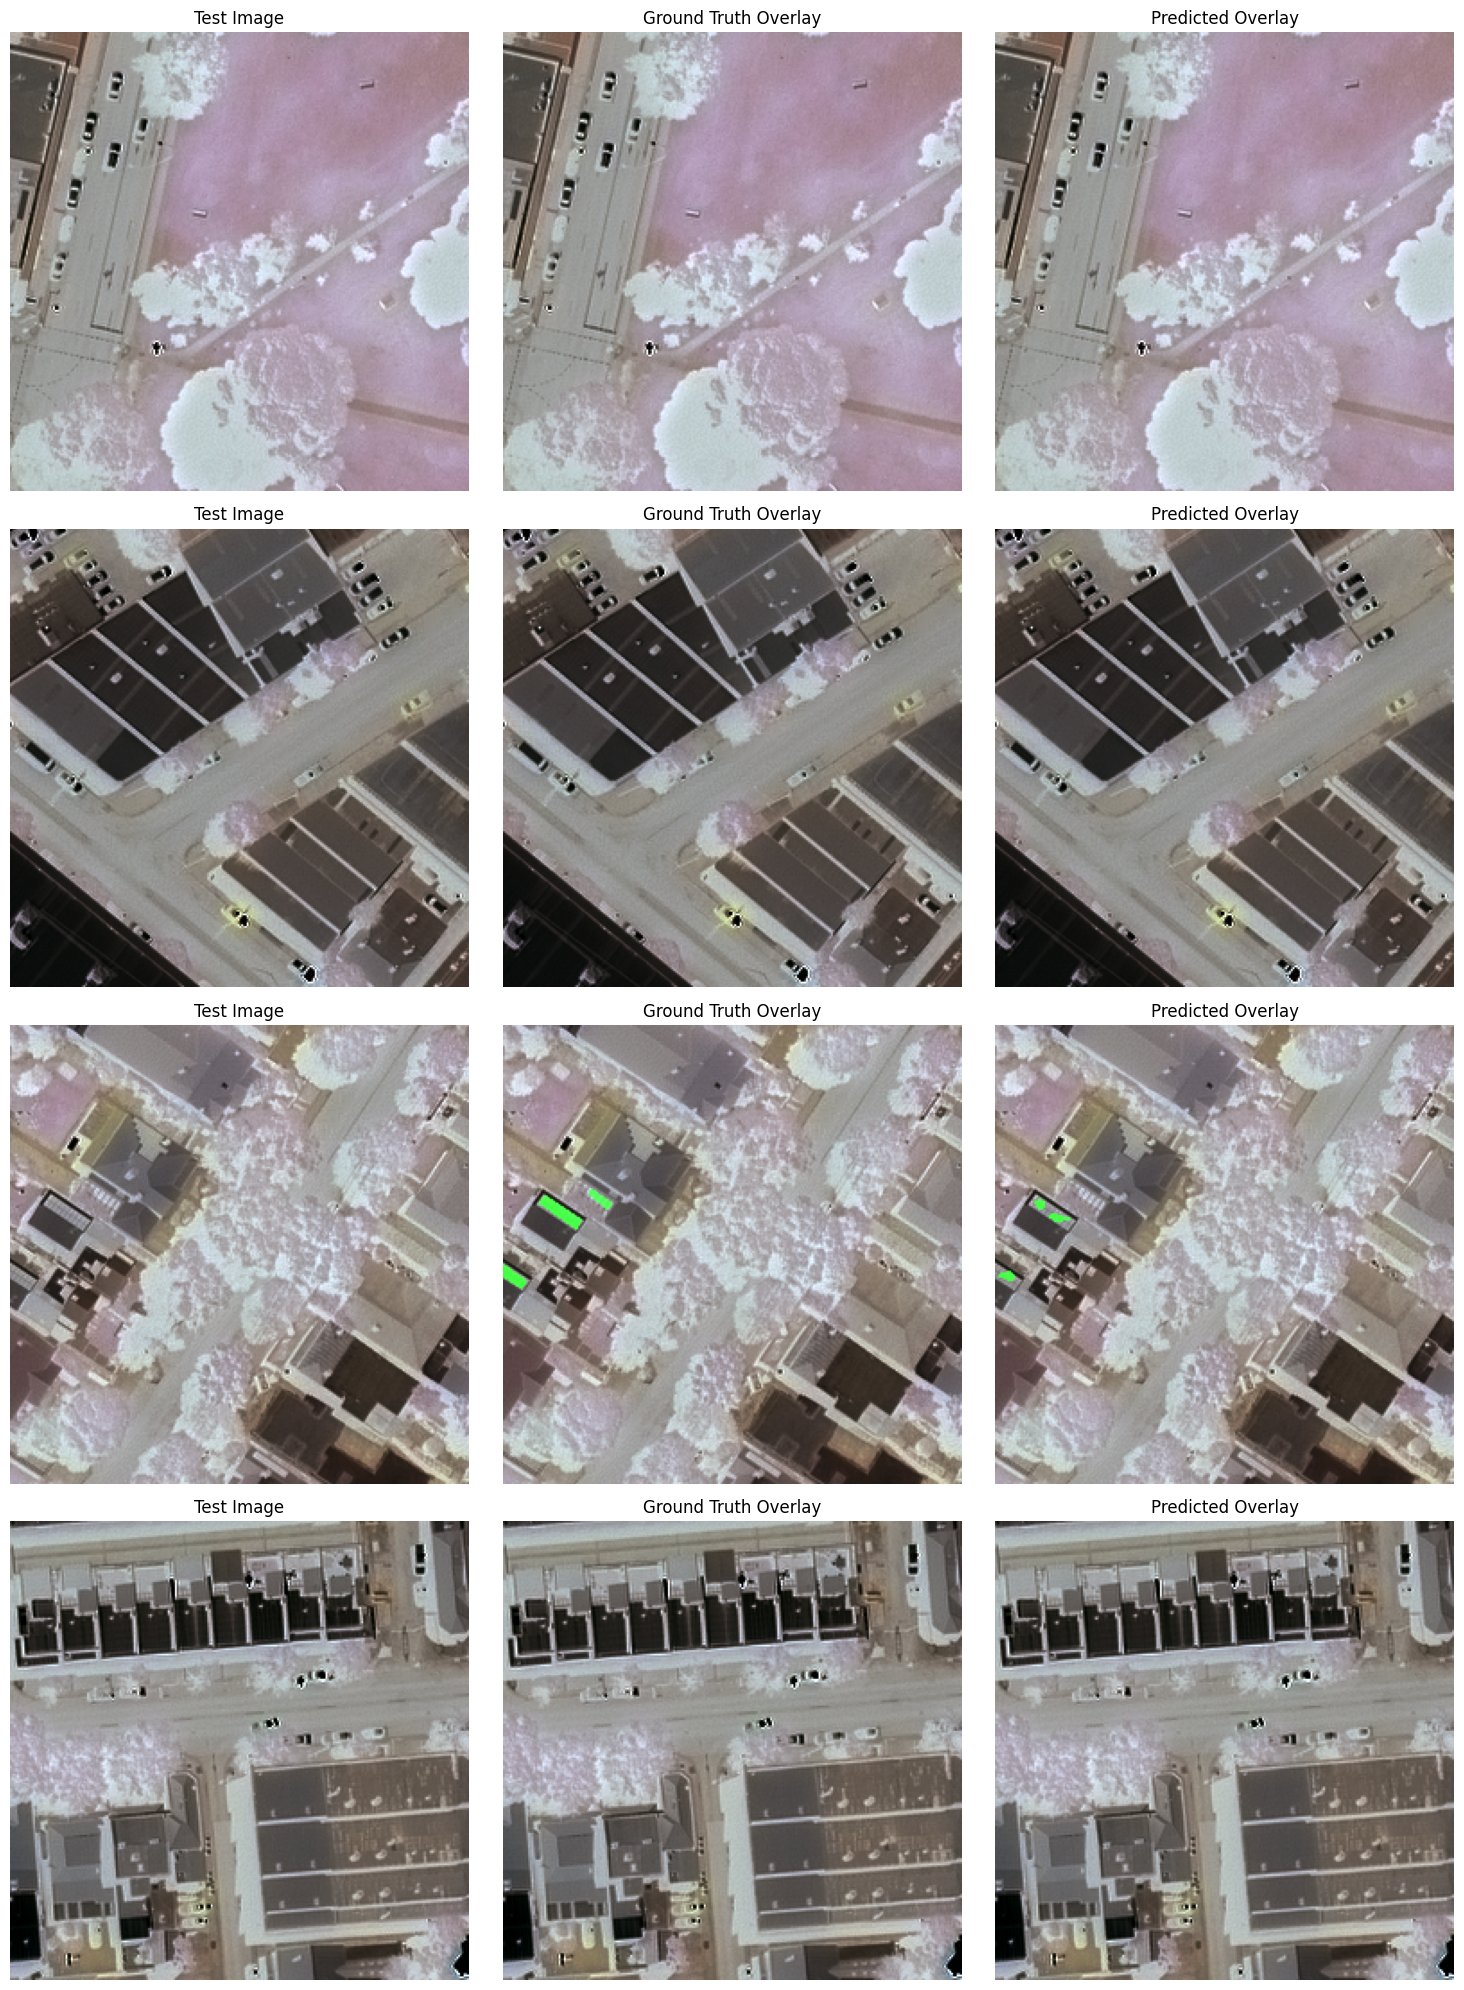

In [19]:
import matplotlib.pyplot as plt

def overlay_mask(image, mask, color=[0, 255, 0], alpha=0.5):
    """Overlay the mask on the image with the specified color and transparency."""
    color = np.array(color)
    overlay = image.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

def plot_overlay_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device, dtype=torch.float), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (batch, height, width, channels)
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Limit the number of images to the batch size
    num_images = min(num_images, len(images))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        # Overlay ground truth mask
        gt_overlay = overlay_mask(images[i], masks[i])
        # Overlay predicted mask
        pred_overlay = overlay_mask(images[i], preds[i])

        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title('Ground Truth Overlay')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_overlay)
        axes[i, 2].set_title('Predicted Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot overlay predictions for a few test images
plot_overlay_predictions(model, test_dataloader, device, num_images=5)

In [21]:
# Validate the model on the second test set
miou2, precision2, recall2, f1_2 = validate(model, test_dataloader_US, device, num_classes)
print(f"Dataset 2 - mIoU: {miou2:.4f}, Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1-Score: {f1_2:.4f}")

Validating: 100%|██████████| 188/188 [00:02<00:00, 67.33it/s]


Dataset 2 - mIoU: 0.5091, Precision: 0.3510, Recall: 0.0232, F1-Score: 0.0434


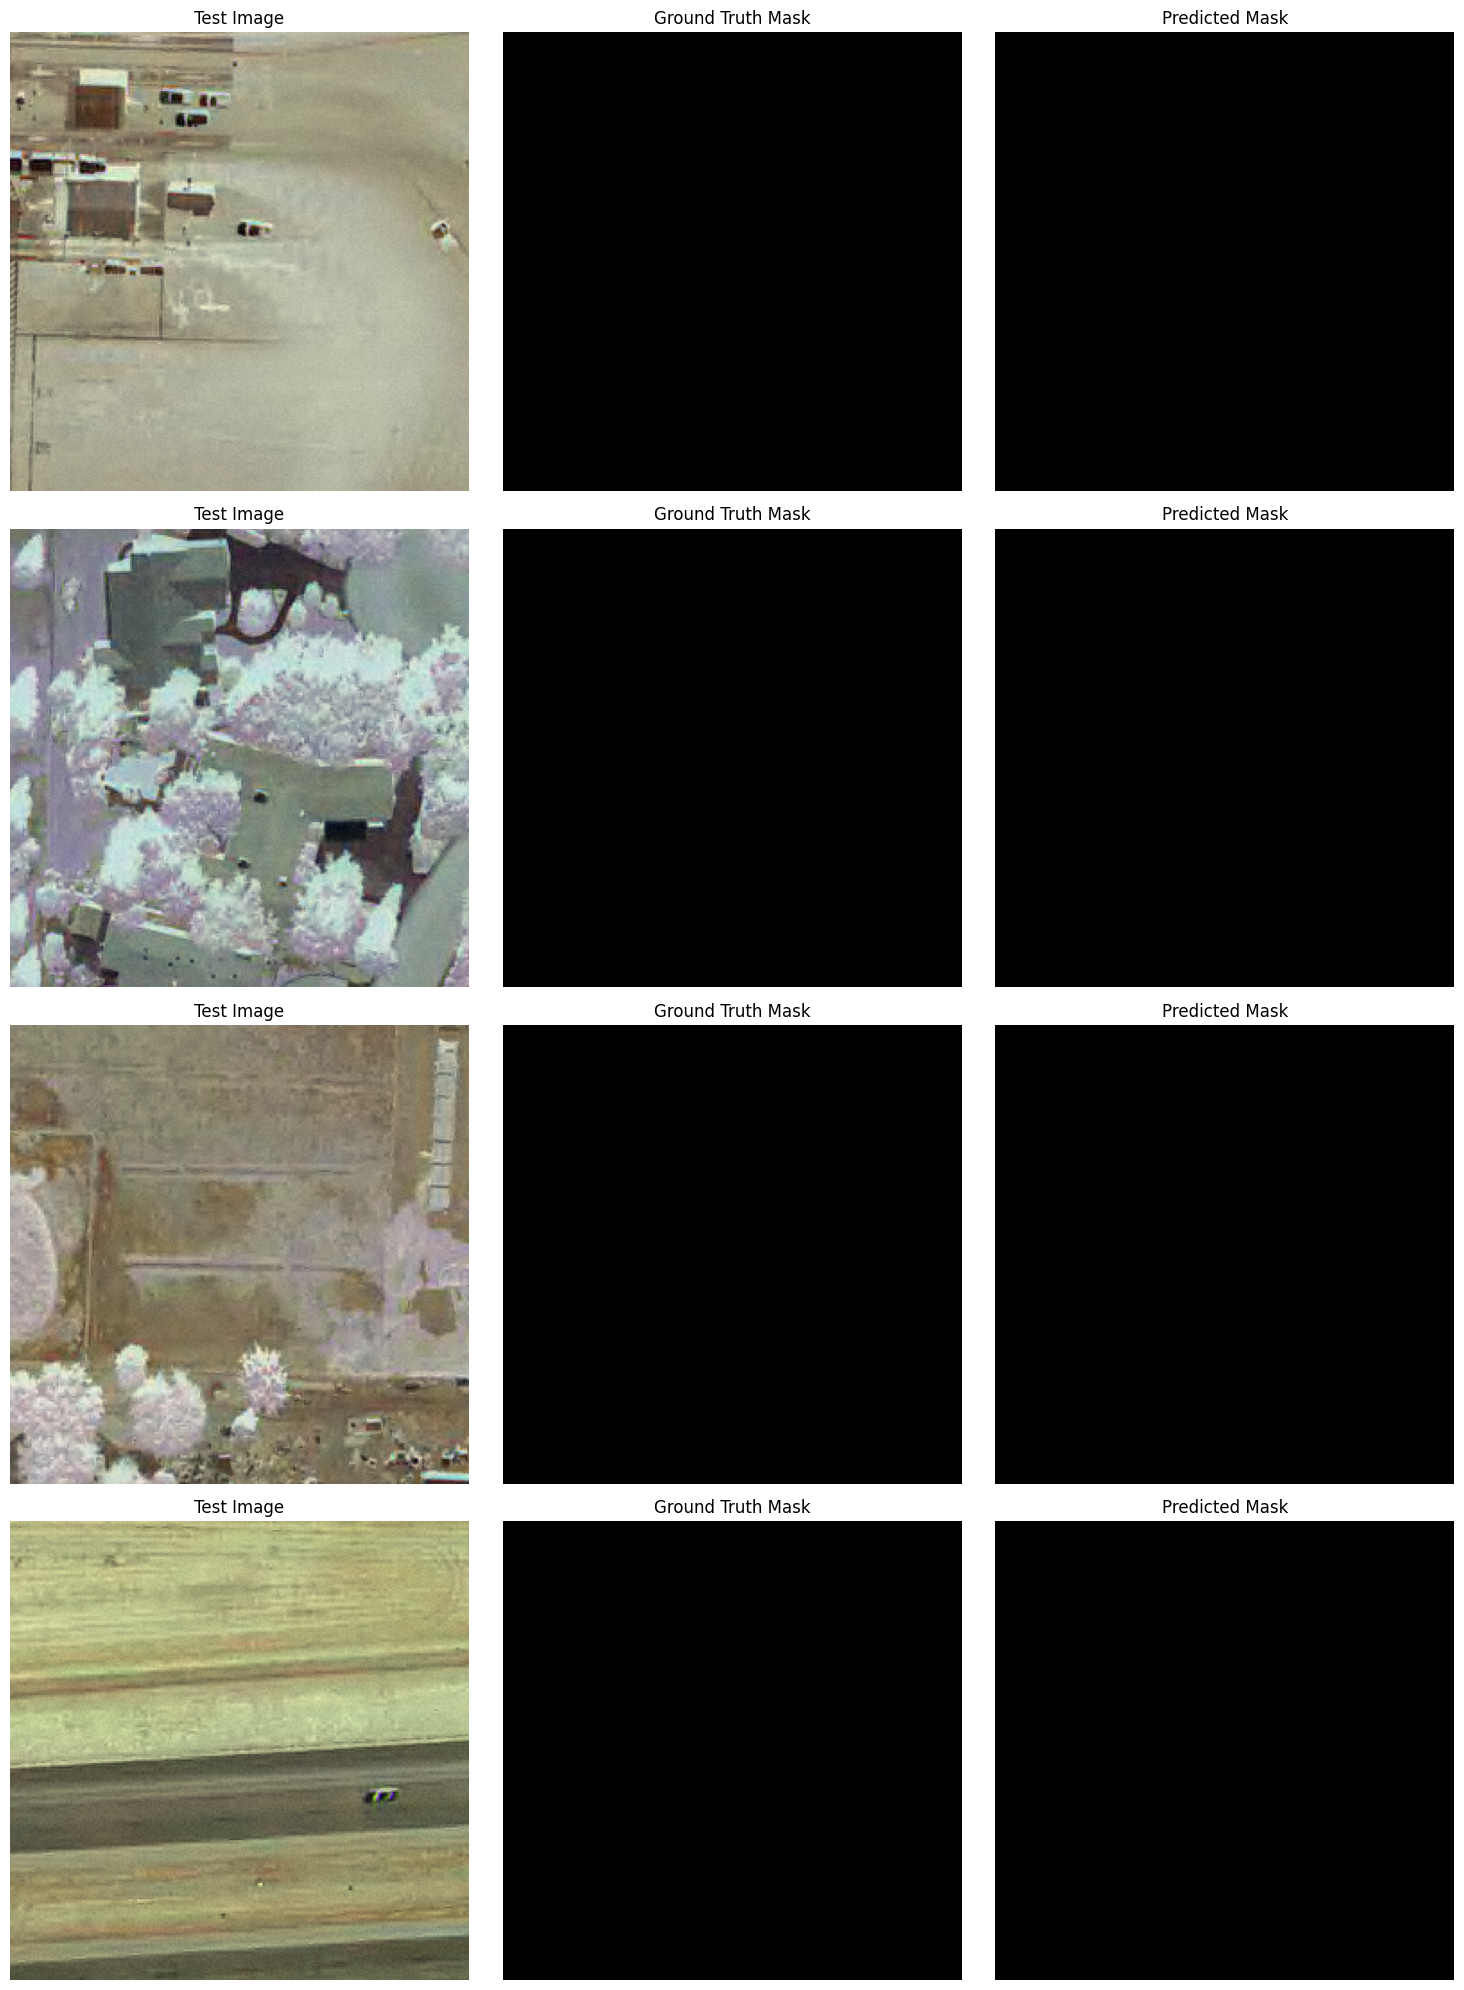

In [22]:
def plot_predictions(model, dataloader, device, num_images=5):
    model.eval()

    # Get a random batch from the dataloader
    random_batch = random.choice(list(dataloader))
    images, masks = random_batch
    images, masks = images.to(device, dtype=torch.float), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Limit the number of images to the batch size
    num_images = min(num_images, len(images))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].transpose(1, 2, 0))
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(preds[i], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot overlay predictions for a few test images
plot_predictions(model, test_dataloader_US, device, num_images=5)